TODO:
- Refactor classes 
- Test properly 

Match-LSTM Layer

- $W^q (l \times l)$
- $H^q (l \times Q)$
- $W^qH^q (l \times Q)$

- $h_{i-1}^r (l \times 1)$
- $W^rh_{i-1}^r (l \times 1)$

(Similarly for $W^ph_i^p$)

In [1]:
import os

In [2]:
import qa_answer

In [3]:
path = '../data/squad'

In [4]:
vocab, rev_vocab = qa_answer.initialize_vocab(os.path.join(path,'vocab.dat'))

In [5]:
def read_data(filename):
    with open(os.path.join(path, filename)) as f:
        data = f.readlines()
    
    return [list(map(int,row.split())) for row in data]

In [6]:
query_data, context_data, spans = [read_data(name) for name in ['train.ids.question', 
                                                                'train.ids.context',
                                                                'train.span']]

In [7]:
len(query_data), len(context_data), len(spans)

(81398, 81398, 81398)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

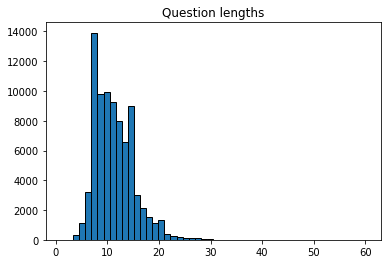

In [10]:
plt.hist(list(map(len, query_data)), ec='k',bins=50)
plt.title('Question lengths')

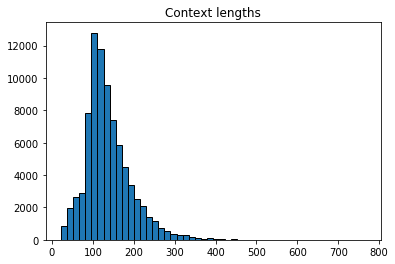

In [11]:
plt.hist(list(map(len, context_data)), ec='k',bins=50)
plt.title('Context lengths')

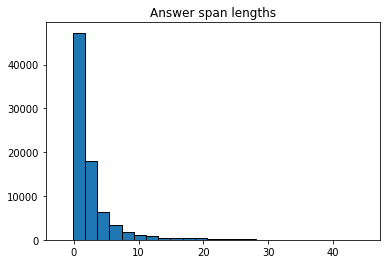

In [12]:
plt.hist(list(map(lambda span: span[1]-span[0], spans)), ec='k',bins=25)
plt.title('Answer span lengths')

Incomplete and rough implementation of the model described in the Match-LSTM paper.

In [13]:
import tensorflow as tf

In [14]:
def make_var(name, shape, dtype):
    return tf.get_variable(name=name, shape=shape, dtype=dtype)

In [15]:
with open(os.path.join(path,'glove.trimmed.100.npz')) as f:
    glove = np.load(f)['glove']

In [16]:
glove = np.float32(glove)
glove.dtype

dtype('float32')

In [226]:
query_lengths = list(map(len,query_data))
context_lengths = list(map(len,context_data))

In [227]:
lstm_units = 300

In [635]:
def run_lstm(ids, lengths, num_units, init_stat_fw = None, init_stat_bw = None):
    embeds = tf.nn.embedding_lookup(glove, ids)
    cell_fw = tf.nn.rnn_cell.LSTMCell(num_units = num_units)
    cell_bw = tf.nn.rnn_cell.LSTMCell(num_units = num_units)
    out, state = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, 
                                                inputs=embeds, 
                                                sequence_length=lengths,
                                                initial_state_fw = init_stat_fw,
                                                initial_state_bw = init_stat_bw,
                                                dtype = tf.float32)
    return out, state

Use the final states of the question LSTM as the initial states of the context LSTM

In [636]:
def tile_batch(weight,num,rank):
    for r in range(rank-len(weight.shape)):
        weight = tf.expand_dims(weight,axis=0)
    return tf.tile(weight, [num]+[1]*(len(weight.shape)-1))

In [637]:
def shape(tensor):
    return tensor.get_shape().as_list()

In [804]:
tf.reset_default_graph()

In [805]:
with tf.variable_scope('placeholders'):
    qids = tf.placeholder(name = 'q_ids', shape=[128,None], dtype = tf.int32)
    cids = tf.placeholder(name = 'c_ids', shape=[128,None], dtype = tf.int32)
    qlen = tf.placeholder(name = 'q_len', shape=[128], dtype = tf.int32)
    clen = tf.placeholder(name = 'c_len', shape=[128], dtype = tf.int32)
    
with tf.variable_scope('q_reps'):
    question_embeds, last_states = run_lstm(qids, qlen, lstm_units)
    question_reps = tf.concat(question_embeds, 2)
    
with tf.variable_scope('c_reps'):
    fw_stat, bw_stat = last_states
    context_embeds, _ = run_lstm(cids, clen, lstm_units, fw_stat, bw_stat)
    context_reps = tf.concat(context_embeds, 2)
    

In [806]:
class MatchLSTM(object):
    def __init__(self, H_p, H_q, P, Q):
        wnames = ['W_'+i for i in 'pqr']
        self.weights = {}
        self.biases = {'b_p':make_var('b_p', shape=[2*lstm_units], dtype=tf.float32)}
        self.biases['b'] = make_var('b',shape=[1], dtype=tf.float32)
        self.embeds = dict(zip(['H_'+i for i in 'pq'], [H_p, H_q]))
            
        self.weights['w'] = make_var('w', shape=[2*lstm_units], dtype=tf.float32)
        
        for wname in wnames:
            self.weights[wname] = make_var(wname, shape=[2*lstm_units,2*lstm_units], dtype=tf.float32)
        
        self.reused_term = tf.matmul(H_q, tile_batch(self.weights['W_q'],128,3))
        self.P = P
        self.Q = Q
        self.cell_fw = tf.nn.rnn_cell.LSTMCell(2*lstm_units)
        self.cell_bw = tf.nn.rnn_cell.LSTMCell(2*lstm_units)
            
    def calculate_attention(self,h_r,i):
        temporal_term = tf.matmul(self.embeds['H_p'][:,i:i+1], tile_batch(self.weights['W_p'],128,3),name='h_pW_p') +\
            tf.matmul(h_r, tile_batch(self.weights['W_r'],128,3), name ='h_rW_r') +\
            tile_batch(self.biases['b_p'],128,3)
        temporal_term_tiled = tf.tile(
            temporal_term, [1,self.Q,1],
            )
        G = tf.tanh(self.reused_term + temporal_term_tiled)
        w_expanded = tf.expand_dims(self.weights['w'],axis=1)
        G_times_w = tf.matmul(G, tile_batch(w_expanded,128,3),name='Gw') 
        alpha = tf.nn.softmax(G_times_w+ tf.tile(tile_batch(self.biases['b'],128,3), [1,self.Q,1]))               
        return alpha

    def make_rnn_inputs(self, h_r, i):
        alpha = self.calculate_attention(h_r,i)
        z = tf.concat([self.embeds['H_p'][:,i:i+1],tf.matmul(alpha, self.embeds['H_q'], transpose_a=True)],2)
        return z
    
    def run_cell(self, i,state=None,bw=False):
        cell = self.cell_bw if bw else self.cell_fw
        state = cell.zero_state(128,dtype=tf.float32) if state is None else state
        index = self.P - 1 - i if bw else i 
        inputs = self.make_rnn_inputs(tf.expand_dims(state.h,axis=1), index)
        _, state = cell(tf.squeeze(inputs, axis=1),state)
        return state

    def run(self):
        H_fw = []
        H_bw = []
        for i in range(self.P):
            state_fw = run_cell(i, state_fw if i else None)
            state_bw = run_cell(i, state_bw if i else None,True)
            H_fw.append(state_fw.h)
            H_bw.append(state_bw.h)
        H_fw = tf.concat(H_fw, 1)
        H_bw = tf.concat(H_bw, 1)
        self.H_r = tf.concat( [H_fw, H_bw], 2)

In [808]:
class AnswerPointer(object):
    def __init__(self, H_r, P):
        self.weights = self._make_vars(['V','W_a','v'],[[2*lstm_units]*2]*2+[2*lstm_units])
        self.biases = self._make_vars(['b_a','c'],[[2*lstm_units],[1]])
        self.H_tilde_r = tf.concat( [H_r,tf.zeros_like(H_r[:,0:1,:])],1) 
        self.H_r = H_r
        self.reused_term = tf.matmul(self.H_tilde_r, tile_batch(self.weights['V'],128,3))
        self.P = P
        with tf.variable_scope('ap'):
            self.cell = tf.nn.rnn_cell.LSTMCell(2*lstm_units)
    
    def _make_vars(self, names, shapes, dtype=tf.float32):
        return dict(zip(names,[make_var(name, shape, dtype) for name,shape in zip(names,shapes)]))
    
    def calculate_attention(self,h_a,i):
        temporal_term = tf.matmul(h_a, tile_batch(self.weights['W_a'],128,3), name ='h_aW_a') +\
            tile_batch(self.biases['b_a'],128,3)
        temporal_term_tiled = tf.tile(
            temporal_term, [1,self.P+1,1],
            )
        F = tf.tanh(self.reused_term + temporal_term_tiled)
        v_expanded = tf.expand_dims(self.weights['v'],axis=1)
        F_times_v = tf.matmul(F, tile_batch(v_expanded,128,3),name='Fv') 
        beta = tf.nn.softmax(F_times_v+ tf.tile(tile_batch(self.biases['c'],128,3), [1,self.P + 1,1]))               
        return beta

    def make_rnn_inputs(self, h_a, i):
        beta = self.calculate_attention(h_a,i)
        z = tf.matmul(beta, self.H_tilde_r, transpose_a=True)
        return z, beta
    
    def run_cell(self, i,state=None):
        cell = self.cell
        state = cell.zero_state(128,dtype=tf.float32) if state is None else state
        inputs, beta = self.make_rnn_inputs(tf.expand_dims(state.h,axis=1), i)
        with tf.variable_scope('ap'):
            _, state = cell(tf.squeeze(inputs, axis=1),state)
        return state, beta
        
    def _make_mask(self,beta):
        return 1-tf.cast(tf.equal(tf.argmax(beta,axis=2), self.P),tf.float32)
    
    def _make_index(self,positions):
        colm1 = tf.range(0,128)
        colm2 = tf.zeros_like(colm1)
        colm3 = positions
        return tf.transpose(tf.stack([colm1,colm2,colm3]))
    
    def run_step(self,k,state=None):
        state, beta = self.run_cell(k, state)
        probs = tf.gather_nd(beta, self._make_index(self.answers[k]))
        return state,tf.log(probs)

    def run(self):
        self.all_probs = []
        for k in range(self.max_answer_length):
            state,logprobs = self.run_step(k,state if k else None)
            #mask = self.mask if train else _make_mask i.e. infer it has stopped
            self.all_probs.append(logprobs*self.mask)
        
        self.loss = -tf.reduce_sum(probs,axis=0)
        